In [1]:
# NumPy: 数値計算用ライブラリ
import numpy as np

# pandas: データ操作・分析用ライブラリ
import pandas as pd

# Matplotlib: グラフ描画用ライブラリ
import matplotlib.pyplot as plt

# Seaborn: 統計データの可視化用ライブラリ（Matplotlibの上位互換）
import seaborn as sns

# LightGBM
import lightgbm as lgb

# 評価指標
from sklearn.metrics import roc_auc_score, roc_curve, auc

# 前処理
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# バリデーション
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

# SHAP
import shap

import warnings
warnings.filterwarnings("ignore")

# 全ての列を表示
pd.set_option('display.max_columns', None)
# 全ての行を表示  
pd.set_option('display.max_rows', None)     

c:\anaconda3\envs\train_model\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 前処理済みのデータの読み込み
df_train = pd.read_csv('./data/processed_train.csv')
df_test = pd.read_csv('./data/processed_test.csv')

In [3]:
# 確認
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,marital_status,car_ownership,children,ProdTaken
0,0,50,Self Enquiry,2,900.0,Large Business,Male,1.0,4.0,Basic,3.0,5.0,1,4,Executive,253905.0,未婚,車未所持,0.0,1.0
1,1,56,Company Invited,1,840.0,Salaried,Male,1.0,4.0,Standard,3.0,2.0,1,4,Senior Manager,404475.0,離婚済み,車所持,0.0,0.0
2,2,0,Self Enquiry,1,600.0,Large Business,Female,1.0,3.0,Basic,3.0,4.0,0,4,Executive,278145.0,結婚済み,車未所持,0.0,1.0
3,3,37,Self Enquiry,2,1080.0,Small Business,Female,1.0,3.0,Standard,4.0,1.0,0,5,Senior Manager,326805.0,離婚済み,車所持,0.0,0.0
4,4,48,Company Invited,3,1020.0,Small Business,Female,1.0,3.0,Basic,4.0,4.0,0,4,Executive,258435.0,独身,車所持,0.0,1.0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   int64  
 2   TypeofContact           3483 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3368 non-null   float64
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3456 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3450 non-null   float64
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [5]:
df_train['ProductPitched'].value_counts()

ProductPitched
Basic           1157
Deluxe          1045
Standard         841
Super Deluxe     320
King             126
Name: count, dtype: int64

In [6]:
# カテゴリーマッピング
TypeofContact_map = {'Self Enquiry': 1, 'Company Invited': 2}
Occupation_map      = {'Small Business': 1, 'Salaried': 2, 'Large Business': 3}
Gender_map          = {'Female': 1, 'Male': 2}
ProductPitched_map  = { 'Basic': 1, 'Deluxe': 2, 'Standard': 3, 'Super Deluxe': 4, 'King': 5}
Designation_map     = {'Executive': 1, 'Manager': 2, 'Senior Manager': 3, 'AVP': 4, 'VP': 5}
MaritalStatus_map   = {'結婚済み': 1, '離婚済み': 2, '独身': 3, '未婚': 4}
CarOwnerShip_map    = {'車未所持': 1, '車所持': 2}

# int型に変換
df_train['TypeofContact'] = df_train['TypeofContact'].map(TypeofContact_map)
df_train['Occupation'] = df_train['Occupation'].map(Occupation_map)
df_train['Gender'] = df_train['Gender'].map(Gender_map)
df_train['ProductPitched'] = df_train['ProductPitched'].map(ProductPitched_map)
df_train['Designation'] = df_train['Designation'].map(Designation_map)
df_train['marital_status'] = df_train['marital_status'].map(MaritalStatus_map)
df_train['car_ownership'] = df_train['car_ownership'].map(CarOwnerShip_map)

df_test['TypeofContact'] = df_test['TypeofContact'].map(TypeofContact_map)
df_test['Occupation'] = df_test['Occupation'].map(Occupation_map)
df_test['Gender'] = df_test['Gender'].map(Gender_map)
df_test['ProductPitched'] = df_test['ProductPitched'].map(ProductPitched_map)
df_test['Designation'] = df_test['Designation'].map(Designation_map)
df_test['marital_status'] = df_test['marital_status'].map(MaritalStatus_map)
df_test['car_ownership'] = df_test['car_ownership'].map(CarOwnerShip_map)

In [7]:
# 特徴量とターゲットの分割
x_train = df_train.drop(columns=['id', 'ProdTaken'])
y_train = df_train[['ProdTaken']]
id_train = df_train[['id']]

print(x_train.shape, y_train.shape, id_train.shape)

(3489, 18) (3489, 1) (3489, 1)


In [8]:
# トレーニングデータとテストデータの分割
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train, random_state=123)
print(X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape)

(2442, 18) (1047, 18) (2442, 1) (1047, 1)


In [9]:
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'verbosity': -1,
    'random_state': 1,
    'max_bin': 255
}
    
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
best_iterations = []
fold_aucs = []
fprs, tprs = [], []

for fold, (train_index, valid_index) in enumerate(kf.split(df_train)):

    # fold毎に訓練データと検証データを作成
    x_tr, x_va = x_train.iloc[train_index], x_train.iloc[valid_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[valid_index]

    # LightGBMのデータセット形式に変換
    dtrain = lgb.Dataset(x_tr, y_tr)
    dvalid = lgb.Dataset(x_va, y_va)

    # LightGBMモデルの作成
    model = lgb.train(params,
                      dtrain,
                      num_boost_round=10000,
                      valid_sets=dvalid,
                      callbacks=[lgb.early_stopping(stopping_rounds=100),
                                 lgb.log_evaluation(1)])
    
    # best_iterationを保存
    best_iterations.append(model.best_iteration)
    print(f'Fold {fold + 1} - Best Iteration: {model.best_iteration}')

    # 予測とROC-AUCの計算
    y_pred = model.predict(x_va, num_iteration=model.best_iteration)
    auc_score = roc_auc_score(y_va, y_pred)
    fold_aucs.append(auc_score)
    print(f'Fold {fold + 1} - ROC-AUC: {auc_score:.2f}')

    # ROCカーブの計算
    fpr, tpr, _ = roc_curve(y_va, y_pred)
    fprs.append(fpr)
    tprs.append(tpr)

[1]	valid_0's binary_error: 0.133238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_error: 0.133238
[3]	valid_0's binary_error: 0.133238
[4]	valid_0's binary_error: 0.133238
[5]	valid_0's binary_error: 0.133238
[6]	valid_0's binary_error: 0.133238
[7]	valid_0's binary_error: 0.133238
[8]	valid_0's binary_error: 0.130372
[9]	valid_0's binary_error: 0.12894
[10]	valid_0's binary_error: 0.126074
[11]	valid_0's binary_error: 0.124642
[12]	valid_0's binary_error: 0.127507
[13]	valid_0's binary_error: 0.12894
[14]	valid_0's binary_error: 0.127507
[15]	valid_0's binary_error: 0.127507
[16]	valid_0's binary_error: 0.12894
[17]	valid_0's binary_error: 0.126074
[18]	valid_0's binary_error: 0.123209
[19]	valid_0's binary_error: 0.123209
[20]	valid_0's binary_error: 0.118911
[21]	valid_0's binary_error: 0.117479
[22]	valid_0's binary_error: 0.116046
[23]	valid_0's binary_error: 0.116046
[24]	valid_0's binary_error: 0.117479
[25]	valid_0's binary_error: 0.116046



Average Best Iteration: 37.00
Average ROC-AUC: 0.83


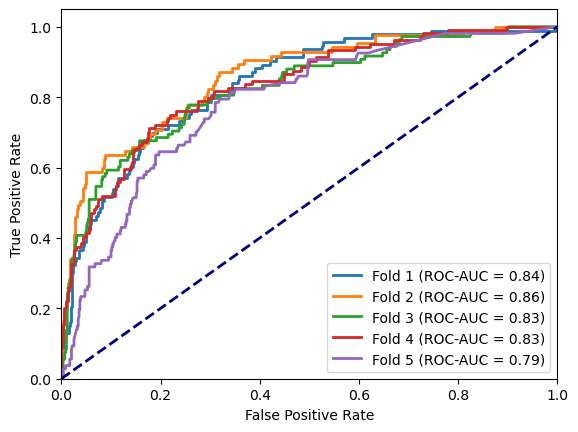

In [10]:
# 各Foldのbest_iterationの平均値
average_best_iteration = round(sum(best_iterations) / n_splits)
print(f'\nAverage Best Iteration: {average_best_iteration:.2f}')

# 各FoldのROC-AUCの平均値
average_auc = sum(fold_aucs) / n_splits
print(f'Average ROC-AUC: {average_auc:.2f}')

# 全FoldのROCカーブを重ねて描画
plt.figure()
for i in range(n_splits):
    plt.plot(fprs[i], tprs[i], lw=2, label=f'Fold {i + 1} (ROC-AUC = {fold_aucs[i]:.2f})')
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

先ほどのクロスバリデーションを用いたモデル訓練時に得られたベストなイテレーション数の平均値(37回)を記録したaverage_best_iterationを設定していきます。

In [11]:
# LightGBM用のデータセットを作成
dtrain = lgb.Dataset(X_valid, Y_valid)

# モデルの訓練
model_final = lgb.train(
    params,
    dtrain,
    num_boost_round=average_best_iteration
)

In [27]:
# テストデータを用いて予測します。
# x_testとid_testを定義
x_test = df_test.drop(['id'], axis=1)
id_test = df_test[['id']]

# テストデータによる予測とROC-AUCの評価
y_test_pred = model_final.predict(x_test, num_iteration=average_best_iteration)

In [28]:
from datetime import datetime

# 提出ファイルの作成
df_submit = pd.DataFrame({'id': id_test['id'], 'ProdTaken': y_test_pred})
print(df_submit.head(5))

# 今日の日付を取得
today = datetime.today().strftime('%Y-%m-%d')

# CSVファイルを保存
file_name = f"./output/submission_{today}.csv"
df_submit.to_csv(file_name, index=None, header=False)


     id  ProdTaken
0  3489   0.026113
1  3490   0.400566
2  3491   0.590952
3  3492   0.178858
4  3493   0.270500


![スクリーンショット 2024-08-05 093057.png](<attachment:スクリーンショット 2024-08-05 093057.png>)
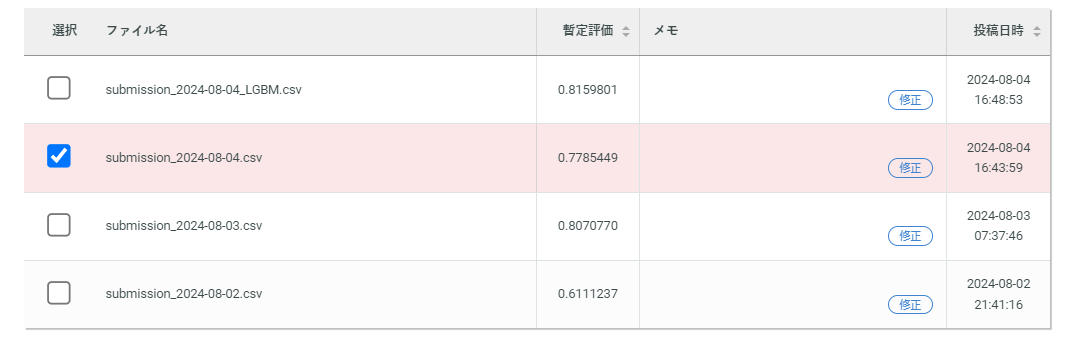